In [1]:
%matplotlib notebook

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpmath import polylog

import scipy 
from scipy import sparse
from scipy.sparse import linalg as spla

In [2]:
def build_generator(N, vs, vd, ve, n=1, dense=False, half=False):
    
    # Inverter transistors 
    
    g_s = np.exp(-vs-ve/2)
    g_d = np.exp(-vd-ve/2)
   
    #Rates for the system
    lpn_s = lambda q1, q2: np.exp((vs + q2*ve)/n)
    lmn_s = lambda q1, q2: lpn_s(q1, q2)*g_s*np.exp(-q1*ve)
        
    lpp_s = lambda q1, q2: np.exp((vs - q2*ve)/n)
    lmp_s = lambda q1, q2: lpp_s(q1, q2)*g_s*np.exp(q1*ve)
    
    #Rates for the demon
    lpn_d = lambda q1, q2: np.exp((vd + q2*ve)/n)
    lmn_d = lambda q1, q2: lpn_d(q1, q2)*g_d*np.exp(-q1*ve)
        
    lpp_d = lambda q1, q2: np.exp((vd - q2*ve)/n)
    lmp_d = lambda q1, q2: lpp_d(q1, q2)*g_d*np.exp(q1*ve)
    
    # Net rates
    
    A1 = lambda q1, q2: lpp_s(q1, q2) + lmn_s(q1, q2) # rate for a transition q1 ->  q1 + qe
    B1 = lambda q1, q2: lmp_s(q1, q2) + lpn_s(q1, q2) # rate for a transition q1 ->  q1 - qe

    A2 = lambda q1, q2: lpp_d(q2, q1) + lmn_d(q2, q1) # rate for a transition q2 ->  q2 + qe
    B2 = lambda q1, q2: lmp_d(q2, q1) + lpn_d(q2, q1) # rate for a transition q2 ->  q2 - qe

        
    rows = []
    cols = []
    data = []
    
    if half:
        R1 = range(0,N+1)
        L1 = N+1
        map_ind = lambda q1, q2: q1 + L1*(N+q2)
    else:
        R1 = range(-N,N+1)
        L1 = 2*N+1
        map_ind = lambda q1, q2: N+q1 + L1*(N+q2)
    
    for q1 in R1:
        for q2 in range(-N,N+1):
            
            ind = map_ind(q1, q2)
            
            if half:
                esc = B1(q1, q2)
            else:
                esc = 0
              
            # arrival from or escape to q1-qe
            if (not half and q1-1 >= -N) or (half and q1-1 >= 0):
                aux = map_ind(q1-1, q2)
                
                arr = A1(q1-1, q2)
                
                if not half:
                    esc += B1(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)
                           
            # arrival from or escape to q1+qe
            if q1+1 <= N:
                aux = map_ind(q1+1, q2)

                arr = B1(q1+1, q2)
                esc += A1(q1, q2)
                
                rows.append(ind)
                cols.append(aux)
                data.append(arr)
 
                
            # arrival from or escape to q2-qe
            if q2-1 >= -N:
                aux = map_ind(q1, q2-1)

                arr = A2(q1, q2-1)
                esc += B2(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

                
            # arrival from or escape to q2+qe
            if q2+1 <= N:
                aux = map_ind(q1, q2+1)
                
                arr = B2(q1, q2+1)
                esc += A2(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

            # escape rate
        
            rows.append(ind) 
            cols.append(ind)
            data.append(-esc)                
    
    if dense:
        gen = np.zeros((L1*(2*N+1), L1*(2*N+1)))
        for r, c, d in zip(rows, cols, data):
            gen[r,c] = d
    else:          
        gen = sparse.coo_matrix((data, (rows, cols)))
    
    return gen


def decode_ss(ss, norm=True):
    
    if norm:
        ss = ss/np.sum(ss)
    
    N = int((np.sqrt(len(ss))-1)/2)
    
    P = np.zeros((2*N+1,2*N+1))
    
    for k in range(len(ss)):
        
        q2 = int(k/(2*N+1)) - N
        q1 = k%(2*N+1) - N
        
        P[N+q1,N+q2] = ss[k][0]
        
    return P

def var_change(P):
    
    N = int((P.shape[0]-1)/2)
    Q = np.zeros((4*N+1,4*N+1))
    
    print(N,Q.shape)
    
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            d = q1 - q2
            s = q1 + q2 
            
            Q[2*N+d, 2*N+s] += P[N+q1,N+q2]
            
    
    return Q

def make_product(P):
    
    P0 = np.sum(P, axis=0)
    P1 = np.sum(P, axis=1)
    
    Q = np.zeros_like(P)
    
    N = int((P.shape[0]-1)/2)

    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            Q[N+q1, N+q2] = P1[N+q1]*P0[N+q2]

    return Q

def exact_g(V, Vd, n):

    if hasattr(V, '__iter__'):
        PLA = np.array([float(polylog(2,-np.exp(Vd+x*(1+2/n)))) for x in V])
        PLB = np.array([float(polylog(2,-np.exp(-Vd+x*(1+2/n)))) for x in V])
    else:
        PLA = float(polylog(2,-np.exp(Vd+V*(1+2/n))))
        PLB = float(polylog(2,-np.exp(-Vd+V*(1+2/n))))
        
    g = V*(2*Vd+V)
    g += (2*n/(n+2))*PLA
    g -= (2*n/(n+2))*PLB
    
    return g

def effective_potential_g(x, vd, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    
    alpha = (Am(-x,x) + Ap(x,-x))/(Am(x,-x) + Ap(-x,x))
    
    return 2*np.log(alpha)

def effective_potential_h(y, vd, xmin=0, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    v1 = xmin + y
    v2 = -xmin + y
    
    beta = (Ap(xmin + y,-xmin + y) + Ap(-xmin + y,xmin + y))/(Am(xmin + y,-xmin + y) + Am(-xmin + y,xmin + y))
    
    return 2*np.log(beta)


def average_currents(P,Vd_o_Vth, qe_o_qth, n=1):
    
    g = np.exp(-Vd_o_Vth-qe_o_qth/2)
    
    lpn = lambda q1, q2: np.exp((Vd_o_Vth + q2*qe_o_qth)/n)
    lmn = lambda q1, q2: lpn(q1, q2)*g*np.exp(-q1*qe_o_qth)
        
    lpp = lambda q1, q2: np.exp((Vd_o_Vth - q2*qe_o_qth)/n)
    lmp = lambda q1, q2: lpp(q1, q2)*g*np.exp(q1*qe_o_qth)
    
    
    N = int((P.shape[0]-1)/2)
    
    In = Ip = 0
           
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            In += (lpn(q1,q2) - lmn(q1,q2))*P[N+q1,N+q2]
            Ip += (lpp(q1,q2) - lmp(q1,q2))*P[N+q1,N+q2]
            
    return In, Ip


def approx_g_1st(V, Vd, n):

    g = V**2 - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    
    return g




In [3]:
vd = 1.4
vs = 1.4
ve =  0.1
slope = 1.0

N = 30

print("Building generator...")
G = build_generator(N, vs, vd, ve)
print("Computing steady state...")
ss = spla.eigs(sparse.csr_matrix(G), k=1, which='SM')
Pss = decode_ss(ss[1])


Building generator...
Computing steady state...


/tmp/ipykernel_77398/3908923201.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  P[N+q1,N+q2] = ss[k][0]


<IPython.core.display.Javascript object>


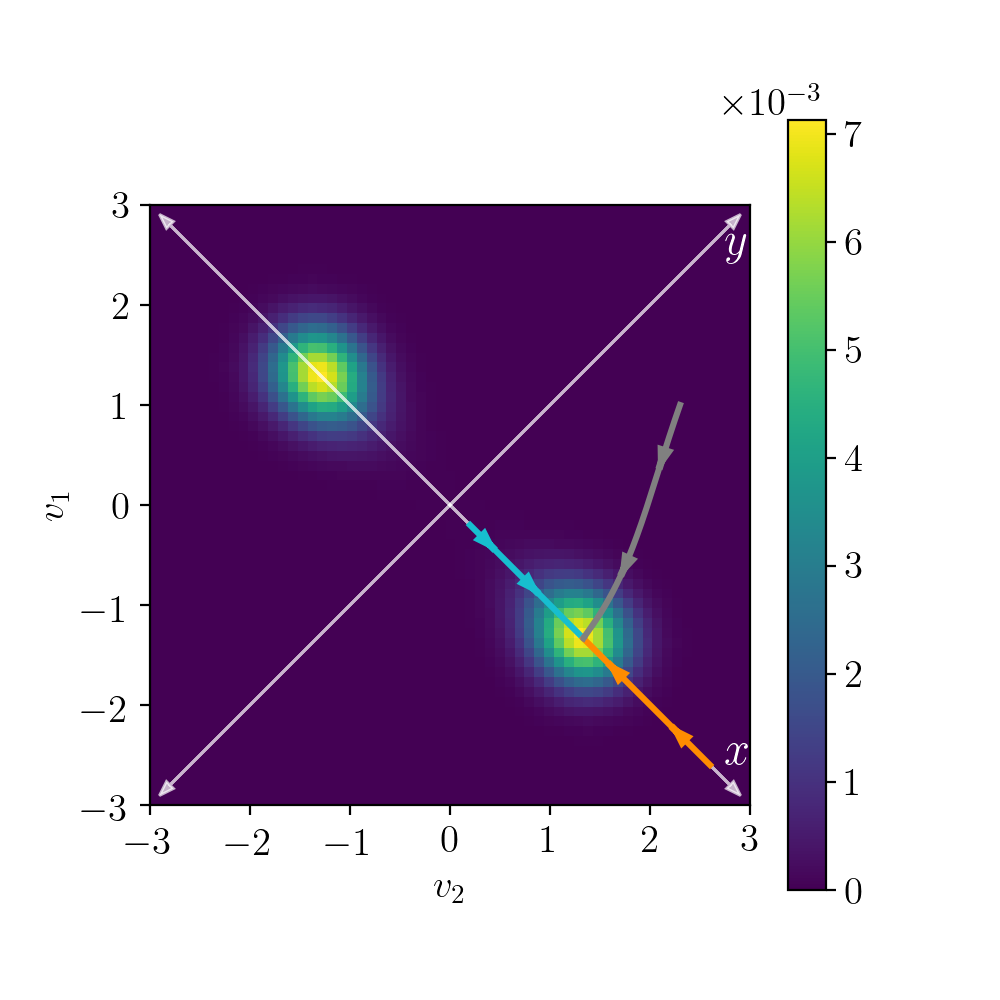

Text(2.75, -2.6, '$x$')

In [4]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=200)
plt.gcf().subplots_adjust(left=.15, hspace=.1)


plt.imshow(Pss, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.xticks([-3,-2,-1,0,1,2,3])
#plt.xticks([-2,-1,0,1,2])

cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

plt.arrow(0,0,2.8,2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,-2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,2.8,-2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)

plt.text(2.75,2.5,"$y$", color="white", fontsize="large")
plt.text(2.75,-2.6,"$x$", color="white", fontsize="large")



In [5]:
V = np.load('traj_ex1_V.npy')
plt.arrow(V[40000,1],V[40000,0],.1*(V[40001,1]-V[40000,1]),.1*(V[40001,0]-V[40000,0]),width=.045,length_includes_head=True,color='C9')
plt.arrow(V[20000,1],V[20000,0],.1*(V[20001,1]-V[20000,1]),.1*(V[20001,0]-V[20000,0]),width=.045,length_includes_head=True,color='C9')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='C9')

V = np.load('traj_ex2_V.npy')
plt.arrow(V[500,1],V[500,0],.1*(V[501,1]-V[500,1]),.1*(V[501,0]-V[500,0]),width=.045,length_includes_head=True,color='darkorange')
plt.arrow(V[5000,1],V[5000,0],.1*(V[5001,1]-V[5000,1]),.1*(V[5001,0]-V[5000,0]),width=.045,length_includes_head=True,color='darkorange')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='darkorange')


V = np.load('traj_ex3_V.npy')
plt.arrow(V[2000,1],V[2000,0],.1*(V[2001,1]-V[2000,1]),.1*(V[2001,0]-V[2000,0]),width=.045,length_includes_head=True,color='gray')
plt.arrow(V[8000,1],V[8000,0],.1*(V[8001,1]-V[8000,1]),.1*(V[8001,0]-V[8000,0]),width=.045,length_includes_head=True,color='gray')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='gray')

plt.savefig('./ss_histogram.pdf')

<IPython.core.display.Javascript object>


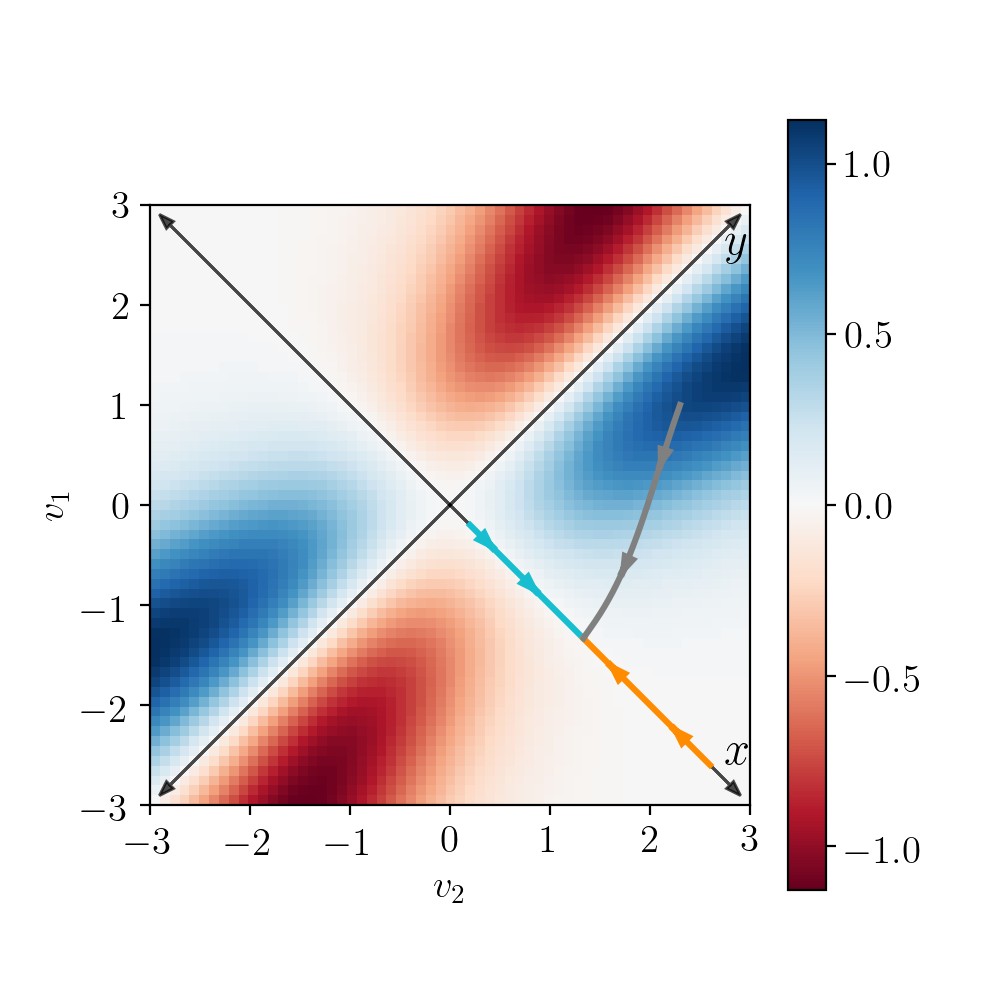

Text(2.75, -2.6, '$x$')

In [6]:
def curl(v1, v2, vs, vd):
    
    C = (4*np.exp(3*v1+3*v2+vs+vd)*(-2*(np.cosh(2*v1-v2)+np.cosh(vd))*np.sinh(vs)+2*(np.cosh(v1-2*v2)+np.cosh(vs))*np.sinh(vd)))/((np.exp(2*v2)+np.exp(v1+vs))*(np.exp(v1)+np.exp(2*v2+vs))*(np.exp(v2)+np.exp(2*v1+vd))*(np.exp(2*v1)+np.exp(v2+vd)))
    
    return C


def curl2(v1, v2, vs, vd, ve):
    
    wp = lambda v1, v2, vdd: np.exp(vdd-v2)
    wm = lambda v1, v2, vdd: wp(v1,v2,vdd)*np.exp(-vdd+v1)  
    
    WP = lambda v1, v2, vdd: wp(v1,v2,vdd) + wm(-v1,-v2,vdd)
    WM = lambda v1, v2, vdd: wm(v1,v2,vdd) + wp(-v1,-v2,vdd)
    
    s1 = lambda v1, v2, vdd: np.log(WP(v1,v2,vdd)/WM(v1,v2,vdd)) 
    s2 = lambda v1, v2, vdd: np.log(WP(v2,v1,vdd)/WM(v2,v1,vdd)) 
    
    C = (s1(v1,v2+ve,vs)-s1(v1,v2,vs))/ve - (s2(v1+ve,v2,vd)-s2(v1,v2,vd))/ve 
    
    return C


C = np.zeros_like(Pss)

for j in range(2*N+1):
    for k in range(2*N+1):
        C[j,k] = curl(ve*(j-N),ve*(k-N),vs,vs)
        #C[j,k] = curl2(ve*(j-N),ve*(k-N),vs,vs,ve)
        
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=200)
plt.gcf().subplots_adjust(left=.15, hspace=.1)

plt.imshow(C, origin='lower', extent=N*ve*np.array([-1,1,-1,1]), cmap='RdBu')
plt.colorbar()

plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.xticks([-3,-2,-1,0,1,2,3])

plt.arrow(0,0,2.8,2.8, linestyle='-', color='black', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,-2.8, linestyle='-', color='black', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,2.8, linestyle='-', color='black', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,2.8,-2.8, linestyle='-', color='black', alpha=.7, head_width=.1, linewidth=1)

plt.text(2.75,2.5,"$y$", color="black", fontsize="large")
plt.text(2.75,-2.6,"$x$", color="black", fontsize="large")



In [7]:
V = np.load('traj_ex1_V.npy')
plt.arrow(V[40000,1],V[40000,0],.1*(V[40001,1]-V[40000,1]),.1*(V[40001,0]-V[40000,0]),width=.045,length_includes_head=True,color='C9')
plt.arrow(V[20000,1],V[20000,0],.1*(V[20001,1]-V[20000,1]),.1*(V[20001,0]-V[20000,0]),width=.045,length_includes_head=True,color='C9')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='C9')

V = np.load('traj_ex2_V.npy')
plt.arrow(V[500,1],V[500,0],.1*(V[501,1]-V[500,1]),.1*(V[501,0]-V[500,0]),width=.045,length_includes_head=True,color='darkorange')
plt.arrow(V[5000,1],V[5000,0],.1*(V[5001,1]-V[5000,1]),.1*(V[5001,0]-V[5000,0]),width=.045,length_includes_head=True,color='darkorange')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='darkorange')


V = np.load('traj_ex3_V.npy')
plt.arrow(V[2000,1],V[2000,0],.1*(V[2001,1]-V[2000,1]),.1*(V[2001,0]-V[2000,0]),width=.045,length_includes_head=True,color='gray')
plt.arrow(V[8000,1],V[8000,0],.1*(V[8001,1]-V[8000,1]),.1*(V[8001,0]-V[8000,0]),width=.045,length_includes_head=True,color='gray')
plt.plot(V[:,1],V[:,0],linewidth=2.2,color='gray')

plt.savefig('curl.pdf')

/tmp/ipykernel_77398/1420462095.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i1 = N+np.int(np.floor((v[0]+ve/2)/ve))
/tmp/ipykernel_77398/1420462095.py:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumP

<IPython.core.display.Javascript object>


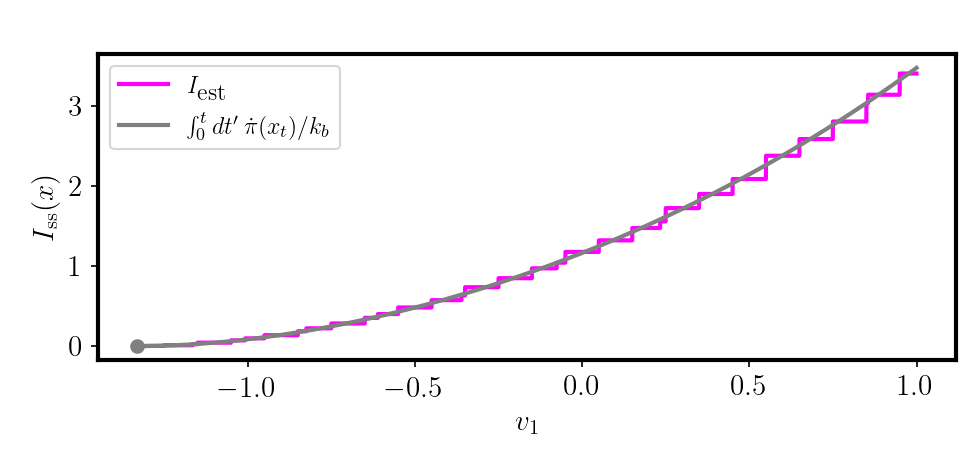

In [8]:
def cg_heat_rate(V, vs, vd):
    
    wp = lambda v1,v2,vdd: np.exp(vdd-v2)
    wm = lambda v1,v2,vdd: wp(v1,v2,vdd)*np.exp(-vdd+v1)  
    
    WP = lambda v1, v2, vdd: wp(v1,v2,vdd) + wm(-v1,-v2,vdd)
    WM = lambda v1, v2, vdd: wm(v1,v2,vdd) + wp(-v1,-v2,vdd)
    
    Q = (WP(V[0],V[1],vs) - WM(V[0],V[1],vs))*np.log(WP(V[0],V[1],vs)/WM(V[0],V[1],vs)) 
    Q += (WP(V[1],V[0],vd) - WM(V[1],V[0],vd))*np.log(WP(V[1],V[0],vd)/WM(V[1],V[0],vd))
    
    return Q



T = np.load('traj_ex3_T.npy')
V = np.load('traj_ex3_V.npy')

cgQ = np.array([cg_heat_rate(v, vs, vd) for v in V])
dt = T[1]-T[0]

I = -np.cumsum(cgQ)*dt

R = []

for v in V:
    i1 = N+np.int(np.floor((v[0]+ve/2)/ve))
    i2 = N+np.int(np.floor((v[1]+ve/2)/ve))
    
    R.append(-np.log(Pss[i1,i2])*ve)
    
    
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

f, ax = plt.subplots(1, 1, sharex=False, figsize=(6.5,3), dpi=150)
plt.gcf().subplots_adjust(right=.98,left=0.10,hspace=.18, bottom=.2)

plt.setp(ax.spines.values(), linewidth=2)
    
ax.plot([v[0] for v in V], R-np.min(R), label=r"$I_\textrm{est}$", linewidth=2, color='magenta')
ax.plot([v[0] for v in V], I-np.min(I), label=r"$\int_0^t dt' \: \dot\pi(x_t)/k_b$", linewidth=2, color='gray')
ax.plot([V[-1][0]],[0],'o',color='gray',label=None)

ax.legend(fontsize='small', loc='upper left')

ax.set_xlabel(r'$v_1$')    
ax.set_ylabel(r'$I_\mathrm{ss}(x)$')    

plt.savefig('last.pdf')
